# MCMC using backward filtering, forward guiding for shapes

Parameter inference for trees with Gaussian transitions along edges and observations at the leaf nodes for landmark represented shapes. Please refer to the notebook [mcmc_Gaussian_BFFG.ipynb](mcmc_Gaussian_BFFG.ipynb) for a simpler version with $\mathbb R^2$ data, and [mcmc_Gaussian_BFFG_shapes.ipynb](mcmc_Gaussian_BFFG_shapes.ipynb) for a version with constant covariance and thus a fully Gaussian model. In the present version, the node covariance is shape depedent, thus requiring computation of likelihood ratios in the downwards passes for use in the MCMC iterations.

The covariance is assumed rotationally invariant, allowing factorization into a kernel product the identity matrix of the ambient space.

The conditioning and upwards/downwards message passing and fusing operations follow the backward filtering, forward guiding approach of Frank van der Meulen, Moritz Schauer et al., see https://arxiv.org/abs/2010.03509 and https://arxiv.org/abs/2203.04155 . The latter reference provides an accesible introduction to the scheme and the notation used in this example. The notation, likelihood ratio calculation etc. follow https://arxiv.org/abs/2203.04155 section 6.1.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
from jax import numpy as jnp
from jax.random import PRNGKey, split

from hyperiax.execution import OrderedExecutor
from hyperiax.models import UpLambdaReducer, DownLambda, UpLambda

from hyperiax.tree.topology import symmetric_topology
from hyperiax.tree import HypTree

from hyperiax.plotting import plot_tree_text, plot_shape_2d, plot_tree_2d_scatter, plot_tree_2d_shape

from hyperiax.mcmc import ParameterStore, VarianceParameter
from hyperiax.mcmc.metropolis_hastings import metropolis_hastings
from hyperiax.mcmc.plotting import trace_plots

from ABFFG import *
from shape import k_K2

import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
# seed,
seed = 42
#import os; seed = int(os.urandom(5).hex(), 16)
key = PRNGKey(seed)

# Shape related setup

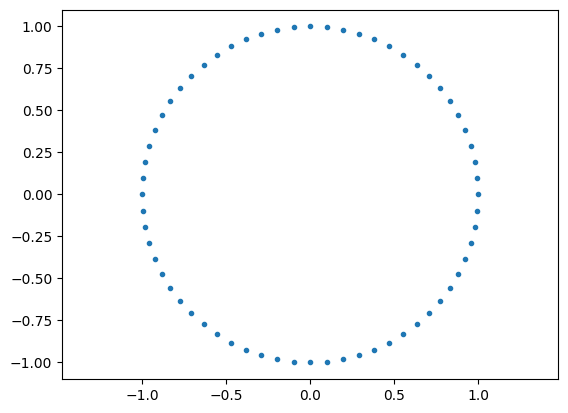

In [4]:
# define shape and plot
d = 2; n = 64 # d = dimension of embedding space (usually 2), n = number of landmarkds
phis = jnp.linspace(0,2*jnp.pi,n,endpoint=False) # circular shape
root = jnp.vstack((jnp.cos(phis),jnp.sin(phis))).T.flatten()

# plot
plot_shape = plot_shape_2d
plot_shape(root)

In [5]:
# diffusion and covariance specification for shape processes
# This version assumes same covariance in all directions (x,y or x,y,z), thus allowing some factorization of the covariance matrix

kQ12 = lambda x,params: (1/n)*k_K2(x,params)

# evaluate k on two pairs of landmark configurations
kQ12_q = lambda q1,q2,params: kQ12(q1.reshape((-1,d))[:,jnp.newaxis,:]-q2.reshape((-1,d))[jnp.newaxis,:,:],params)

# diffusion field and covariance matrix factored in dimensions
sigma = lambda q,theta: kQ12_q(q,q,theta) # diffusion field, kernel evaluated on all landmark pairs
def a(q,theta): sigmaq = sigma(q,theta); return jnp.einsum('ij,kj->ik',sigmaq,sigmaq) # covariance
# multiply on the factorized matrix, e.g. covariance matrix
dot = lambda A,v: jnp.einsum('ij,jd->id',A,v.reshape((n,d))).flatten()
# multiple on inverse factorized matrix, e.g. inverse covariance matrix
solve = lambda A,v: jnp.linalg.solve(A,v.reshape((n,d))).flatten()

# Gaussian tree, node-dependent covariance

First, we initialize the tree. We set the root to the shape defined above.

In [6]:
# create topology and tree
topology = symmetric_topology(height=2, degree=5)
plot_tree_text(topology)
tree = HypTree(topology)
print(tree)

# add properties to tree
tree.add_property('edge_length', shape=())
# data dimension
d = 2
tree.add_property('value', shape=(n*d,))
tree.add_property('noise', shape=(n*d,))

# set edge lengths on all nodes
tree.data['edge_length'] = jnp.ones_like(tree.data['edge_length'])

# root value
tree.data['value'] = tree.data['value'].at[0].set(root)

                        o
    ┌─────────┬─────────┼─────────┬─────────┐
    o         o         o         o         o    
┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐ ┌─┬─┼─┬─┐
o o o o o o o o o o o o o o o o o o o o o o o o o


HypTree(size=31, levels=3, leaves=25, inner nodes=5)


We then define parameters for the Gaussian transition kernel.

In [7]:
# parameters, variance and observation noise
params = ParameterStore({
    'k_alpha': VarianceParameter(.3), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3) # observation noise variance
    })

Now follows the down transitions. At first, we define the unconditional transitions, which are just Gaussian samples. The covariance is sqare of the pairwise kernel evaluations in `sigma(params)` times the variance parameter times edge lengths.

In [8]:
# vmapped version of down_unconditional. In this version, the function takes a single node, not a batch (contrast to the batched version in mcmc_Gaussian_BFFG.ipynb)
@jax.jit
def down_unconditional(noise,edge_length,parent_value,params,**args):
    def f(noise,edge_length,parent_value):
        var = edge_length # variance is edge length
        return {'value': parent_value+jnp.sqrt(var)*dot(sigma(parent_value,params),noise)}

    return jax.vmap(f)(noise,edge_length,parent_value)
downmodel_unconditional = DownLambda(down_fn=down_unconditional)
down_unconditional = OrderedExecutor(downmodel_unconditional)

We can now draw noise and perform a downwards pass. This gives values at all nodes of the tree. Note that observation noise is not added to the leaves yet.

In [9]:
# sample new noise
def update_noise(tree,key): 
    tree.data['noise'] = jax.random.normal(key, shape=tree.data['noise'].shape)

subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())

Add uncorrelated observation noise to leaves.



In [10]:
# copy the sampled tree and add noise to leaf nodes
key, subkey = split(key)
leaf_values = tree.data['value'][tree.is_leaf]+jnp.sqrt(params['obs_var'].value)*jax.random.normal(subkey,tree.data['value'][tree.is_leaf].shape)
tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(leaf_values)

Plot a generated tree.

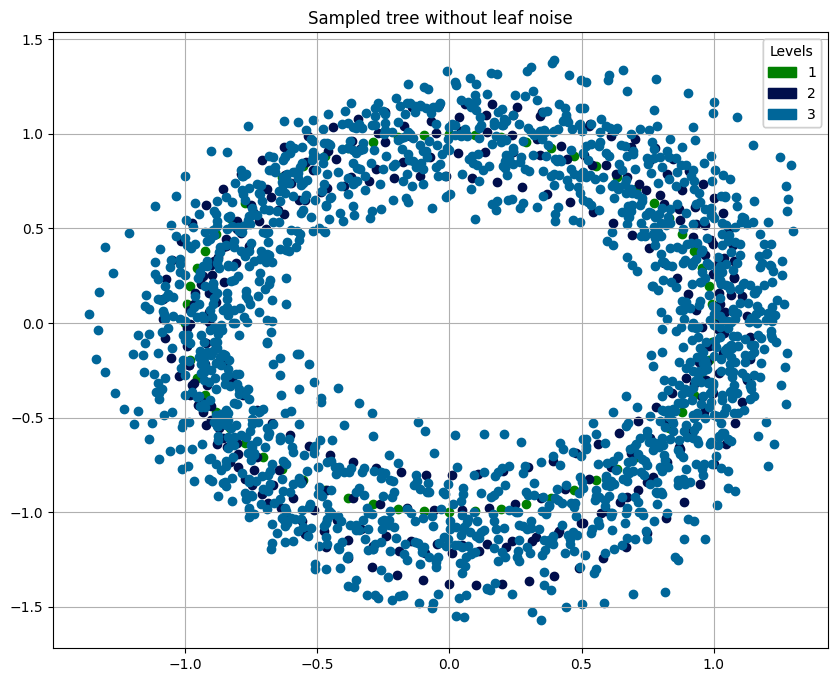

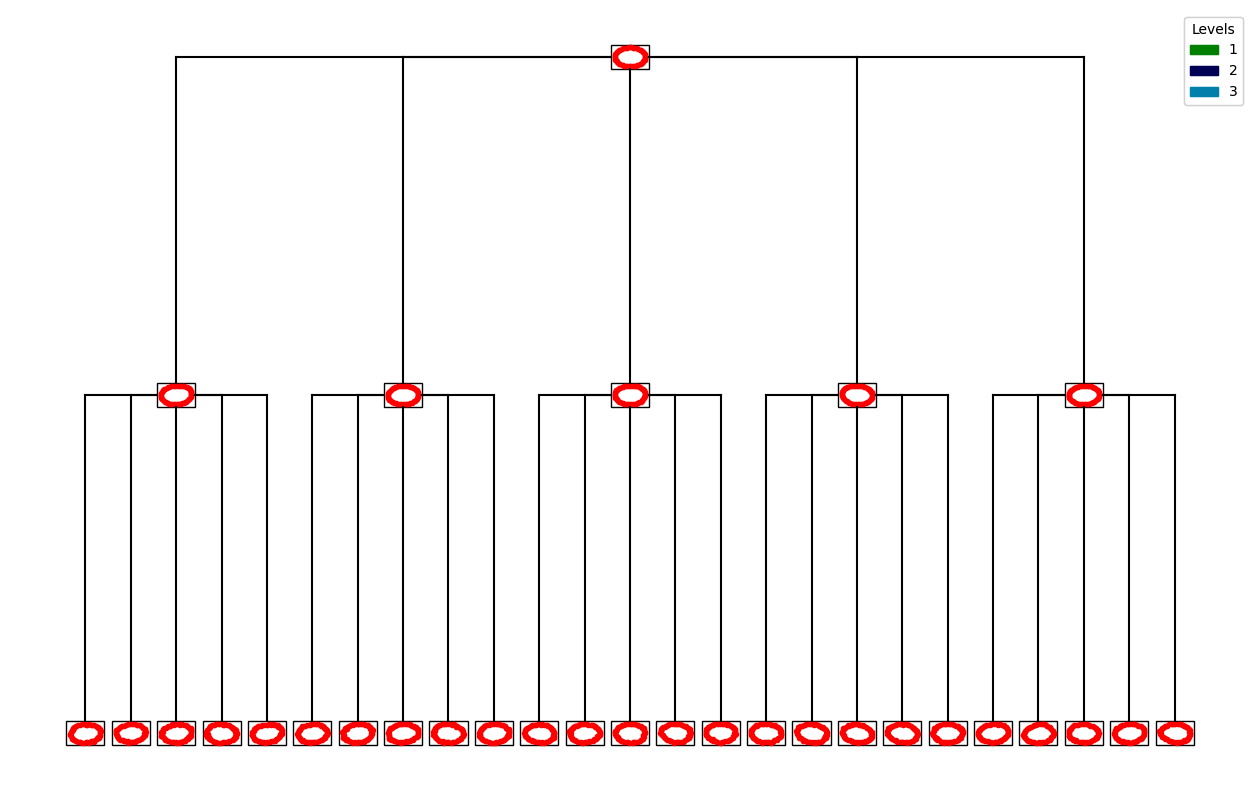

In [11]:
fig,ax = plt.subplots(figsize=(10,8))
plot_tree_2d_scatter(tree,'value',selector=lambda z: z.reshape((1,n,d)),ax=ax)
plt.gca().set_title('Sampled tree without leaf noise')

plot_tree_2d_shape(tree,'value')

# Backwards filtering, forward guiding

We now define the backwards filter through the up function. The Gaussian are parametrized in the $(c,F,H)$ format make the fuse just a sum of the results of the up operation. See https://arxiv.org/abs/2203.04155 for details.

In [12]:
# backwards filter
@jax.jit
def up(noise,edge_length,c_T,F_T,H_T,params,**args):
    def f(edge_length,c_T,F_T,H_T):
        var = edge_length # variance is edge length

        #Sigma_T = jnp.linalg.inv(H_T) # alt. Q_T
        #v_T = dot(Sigma_T,F_T)
        v_T = solve(H_T,F_T)
        covar = var*a(v_T,params) # covariance matrix
    
        invPhi_0 = (jnp.eye(n)+H_T@covar)
        #Sigma_0 = Sigma_T@invPhi_0 # = Sigma_T+covar, alt. C_0
        Sigma_0 = jnp.linalg.solve(H_T,invPhi_0) # = Sigma_T+covar, alt. C_0
        #H_0 = jnp.linalg.inv(Sigma_0) # hat H
        H_0 = jnp.linalg.solve(invPhi_0,H_T) # hat H
        F_0 = solve(invPhi_0,F_T) # hat F
        v_0 = dot(Sigma_0,F_0)
        c_0 = jax.vmap(
            lambda v_T,c_T,F_T: c_T-logphi_H(jnp.zeros(n),v_T,H_T)+logphi_H(jnp.zeros(n),v_T,H_0), # = (c_T-logphi_can(jnp.zeros(n),F_T,H_T))+logphi_H(jnp.zeros(n),v_T,H_0)
            (1,0,1))(v_T.reshape((n,d)),c_T.reshape(d),F_T.reshape((n,d)))

        return {'c_0': c_0, 'F_0': F_0, 'H_0': H_0}
    return jax.vmap(f)(edge_length,c_T,F_T,H_T)
def transform(child_c_0,child_F_0,child_H_0,**args):
    F_T = child_F_0
    H_T = child_H_0
    return {'c_T': jax.vmap(lambda F_T,H_T: jax.vmap(lambda F_T: logphi_can(jnp.zeros(n),F_T,H_T),1)(F_T.reshape((n,d))))(F_T,H_T), 'F_T': F_T, 'H_T': H_T}
upmodel = UpLambdaReducer(up, transform,
                   reductions={
                       'c_0': 'sum',
                       'F_0': 'sum',
                       'H_0': 'sum',
                    }
        )
up = OrderedExecutor(upmodel)

We initialize the tree for up by computing the $c,F,H$-values at the leaves.

In [13]:
# initialize tree for up
tree.add_property('c_0', shape=(d,)); tree.add_property('F_0', shape=(n*d,)); tree.add_property('H_0', shape=(n,n)); tree.add_property('c_T', shape=(d,)); tree.add_property('F_T', shape=(n*d,)); tree.add_property('H_T', shape=(n,n)); tree.add_property('logw')
def init_up(leaf_values,params):
    tree.data['value'] = tree.data['value'].at[tree.is_leaf].set(leaf_values)
    tree.data['H_T'] = tree.data['H_T'].at[tree.is_leaf].set((jnp.eye(n)/params['obs_var'].value)[None,:,:])
    tree.data['F_T'] = tree.data['F_T'].at[tree.is_leaf].set(jax.vmap(lambda H,v: dot(H,v))(tree.data['H_T'][tree.is_leaf],leaf_values))
    Sigma = params['obs_var'].value*jnp.eye(n)
    tree.data['c_T'] = tree.data['c_T'].at[tree.is_leaf].set(jax.vmap(lambda v: jax.vmap(lambda v: logphi(jnp.zeros(n),v,Sigma),1)(v.reshape((n,d))))(leaf_values))


We can now define the conditional downwards pass, i.e. the forwards guiding.

In [14]:
@jax.jit
def down_conditional(noise,edge_length,c_0,F_0,H_0,F_T,H_T,parent_value,params,**args):
    def f(noise,edge_length,c_0,F_0,H_0,F_T,H_T,parent_value):
        x = parent_value
        var = edge_length # variance is edge length
        covar = var*a(parent_value,params) # covariance matrix

        #invSigma = jnp.linalg.inv(covar)
        Sigma = covar
        #H = H_T+invSigma
        invH = jnp.linalg.solve(jnp.eye(n)+Sigma@H_T,Sigma)
        #mu = solve(H,F_T+dot(invSigma,x))
        mu = dot(invH,F_T+solve(Sigma,x))

        # for likelihood ratio
        #Sigma_T = jnp.linalg.inv(H_T)
        Sigma_T = invH
        v_T = dot(Sigma_T,F_T) # solve(H_T,F_T)

        # test
        #Sigma_0 = jnp.linalg.inv(H_0)
        #v_0 = dot(Sigma_0,F_0)
        v_0 = solve(H_0,F_0)

        inv_covar_Sigma_T = jnp.linalg.solve(jnp.eye(n)+H_T@Sigma_T,H_T) # inv(covar+Sigma_T)

        return {
            #'value': mu+jax.scipy.linalg.solve_triangular(jax.scipy.linalg.cholesky(H,lower=True),noise.reshape((n,d))).flatten(),
            'value': mu+dot(jax.scipy.linalg.cholesky(invH,lower=True),noise),
            #'value': mu+dot(jax.scipy.linalg.sqrtm(invH),noise),
            'logw': jnp.sum(jax.vmap(
                #lambda v_T,parent_value,c_0,F_0: logphi(v_T,parent_value,covar+Sigma_T)-logU(parent_value,c_0,F_0,H_0),
                lambda v_T,parent_value,c_0,F_0: logphi_H(v_T,parent_value,inv_covar_Sigma_T)-logU(parent_value,c_0,F_0,H_0),
                (1,1,0,1))(v_T.reshape((n,d)),parent_value.reshape((n,d)),c_0.reshape(d),F_0.reshape((n,d)))),
            }

    return jax.vmap(f)(noise,edge_length,c_0,F_0,H_0,F_T,H_T,parent_value)
downmodel_conditional = DownLambda(down_fn=down_conditional)
down_conditional = OrderedExecutor(downmodel_conditional)

We make an upwards pass and a downwards conditional sampling to test. Subsequently, we time the three operations (uncondtional down, conditional down, and up).

In [15]:
# backwards filter and fowards guiding
init_up(leaf_values,params)
up.up(tree,params.values())
down_conditional.down(tree,params.values())

# time the operations
subkey, key = split(key)
update_noise(tree,subkey)
down_unconditional.down(tree,params.values())
%time down_unconditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time down_conditional.down(tree,params.values()); jax.block_until_ready(tree.data['value'])
%time up.up(tree,params.values()); jax.block_until_ready(tree.data['H_0'])
None

CPU times: user 1.05 ms, sys: 358 μs, total: 1.41 ms
Wall time: 448 μs
CPU times: user 14.2 ms, sys: 2.36 ms, total: 16.6 ms
Wall time: 13 ms
CPU times: user 11.9 ms, sys: 1.73 ms, total: 13.6 ms
Wall time: 10.7 ms


# MCMC

MCMC run incorporating the likelihood ratios arising from the Gaussian approximation.

Initial parameters:  {'k_alpha': 0.5, 'k_sigma': 0.25, 'obs_var': 0.001}
data parameters:  {'k_alpha': 0.3, 'k_sigma': 0.5, 'obs_var': 0.001}


  0%|                                                                                                                                                                                                 | 0/1200 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                                                        | 2/1200 [00:00<01:07, 17.79it/s]

  0%|▉                                                                                                                                                                                        | 6/1200 [00:00<00:45, 26.00it/s]

  1%|█▌                                                                                                                                                                                      | 10/1200 [00:00<00:41, 28.41it/s]

  1%|██▏                                                                                                                                                                                     | 14/1200 [00:00<00:40, 29.38it/s]

  2%|██▊                                                                                                                                                                                     | 18/1200 [00:00<00:39, 29.97it/s]

  2%|███▎                                                                                                                                                                                    | 22/1200 [00:00<00:38, 30.31it/s]

  2%|███▉                                                                                                                                                                                    | 26/1200 [00:00<00:38, 30.71it/s]

  2%|████▌                                                                                                                                                                                   | 30/1200 [00:01<00:37, 30.98it/s]

  3%|█████▏                                                                                                                                                                                  | 34/1200 [00:01<00:37, 31.01it/s]

  3%|█████▊                                                                                                                                                                                  | 38/1200 [00:01<00:37, 31.09it/s]

  4%|██████▍                                                                                                                                                                                 | 42/1200 [00:01<00:37, 31.24it/s]

  4%|███████                                                                                                                                                                                 | 46/1200 [00:01<00:36, 31.35it/s]

  4%|███████▋                                                                                                                                                                                | 50/1200 [00:01<00:36, 31.44it/s]

  4%|████████▎                                                                                                                                                                               | 54/1200 [00:01<00:36, 31.37it/s]

  5%|████████▉                                                                                                                                                                               | 58/1200 [00:01<00:36, 31.32it/s]

  5%|█████████▌                                                                                                                                                                              | 62/1200 [00:02<00:36, 31.37it/s]

  6%|██████████                                                                                                                                                                              | 66/1200 [00:02<00:36, 31.29it/s]

  6%|██████████▋                                                                                                                                                                             | 70/1200 [00:02<00:36, 31.32it/s]

  6%|███████████▎                                                                                                                                                                            | 74/1200 [00:02<00:36, 31.26it/s]

  6%|███████████▉                                                                                                                                                                            | 78/1200 [00:02<00:36, 31.15it/s]

  7%|████████████▌                                                                                                                                                                           | 82/1200 [00:02<00:35, 31.12it/s]

  7%|█████████████▏                                                                                                                                                                          | 86/1200 [00:02<00:35, 31.08it/s]

  8%|█████████████▊                                                                                                                                                                          | 90/1200 [00:02<00:35, 31.20it/s]

  8%|██████████████▍                                                                                                                                                                         | 94/1200 [00:03<00:35, 31.26it/s]

  8%|███████████████                                                                                                                                                                         | 98/1200 [00:03<00:35, 31.10it/s]

  8%|███████████████▌                                                                                                                                                                       | 102/1200 [00:03<00:35, 31.32it/s]

  9%|████████████████▏                                                                                                                                                                      | 106/1200 [00:03<00:34, 31.47it/s]

  9%|████████████████▊                                                                                                                                                                      | 110/1200 [00:03<00:34, 31.49it/s]

 10%|█████████████████▍                                                                                                                                                                     | 114/1200 [00:03<00:34, 31.58it/s]

 10%|█████████████████▉                                                                                                                                                                     | 118/1200 [00:03<00:34, 31.59it/s]

 10%|██████████████████▌                                                                                                                                                                    | 122/1200 [00:03<00:34, 31.60it/s]

 10%|███████████████████▏                                                                                                                                                                   | 126/1200 [00:04<00:33, 31.66it/s]

 11%|███████████████████▊                                                                                                                                                                   | 130/1200 [00:04<00:33, 31.65it/s]

 11%|████████████████████▍                                                                                                                                                                  | 134/1200 [00:04<00:33, 31.82it/s]

 12%|█████████████████████                                                                                                                                                                  | 138/1200 [00:04<00:33, 31.87it/s]

 12%|█████████████████████▋                                                                                                                                                                 | 142/1200 [00:04<00:33, 31.80it/s]

 12%|██████████████████████▎                                                                                                                                                                | 146/1200 [00:04<00:33, 31.88it/s]

 12%|██████████████████████▉                                                                                                                                                                | 150/1200 [00:04<00:32, 31.99it/s]

 13%|███████████████████████▍                                                                                                                                                               | 154/1200 [00:04<00:32, 31.87it/s]

 13%|████████████████████████                                                                                                                                                               | 158/1200 [00:05<00:32, 31.93it/s]

 14%|████████████████████████▋                                                                                                                                                              | 162/1200 [00:05<00:32, 31.60it/s]

 14%|█████████████████████████▎                                                                                                                                                             | 166/1200 [00:05<00:32, 31.47it/s]

 14%|█████████████████████████▉                                                                                                                                                             | 170/1200 [00:05<00:32, 31.59it/s]

 14%|██████████████████████████▌                                                                                                                                                            | 174/1200 [00:05<00:32, 31.64it/s]

 15%|███████████████████████████▏                                                                                                                                                           | 178/1200 [00:05<00:32, 31.70it/s]

 15%|███████████████████████████▊                                                                                                                                                           | 182/1200 [00:05<00:32, 31.72it/s]

 16%|████████████████████████████▎                                                                                                                                                          | 186/1200 [00:05<00:31, 31.83it/s]

 16%|████████████████████████████▉                                                                                                                                                          | 190/1200 [00:06<00:31, 31.83it/s]

 16%|█████████████████████████████▌                                                                                                                                                         | 194/1200 [00:06<00:31, 31.91it/s]

 16%|██████████████████████████████▏                                                                                                                                                        | 198/1200 [00:06<00:31, 31.84it/s]

 17%|██████████████████████████████▊                                                                                                                                                        | 202/1200 [00:06<00:31, 31.86it/s]

 17%|███████████████████████████████▍                                                                                                                                                       | 206/1200 [00:06<00:31, 31.84it/s]

 18%|████████████████████████████████                                                                                                                                                       | 210/1200 [00:06<00:31, 31.83it/s]

 18%|████████████████████████████████▋                                                                                                                                                      | 214/1200 [00:06<00:31, 31.53it/s]

 18%|█████████████████████████████████▏                                                                                                                                                     | 218/1200 [00:06<00:31, 31.46it/s]

 18%|█████████████████████████████████▊                                                                                                                                                     | 222/1200 [00:07<00:31, 31.51it/s]

 19%|██████████████████████████████████▍                                                                                                                                                    | 226/1200 [00:07<00:30, 31.57it/s]

 19%|███████████████████████████████████                                                                                                                                                    | 230/1200 [00:07<00:30, 31.65it/s]

 20%|███████████████████████████████████▋                                                                                                                                                   | 234/1200 [00:07<00:30, 31.64it/s]

 20%|████████████████████████████████████▎                                                                                                                                                  | 238/1200 [00:07<00:30, 31.55it/s]

 20%|████████████████████████████████████▉                                                                                                                                                  | 242/1200 [00:07<00:30, 31.62it/s]

 20%|█████████████████████████████████████▌                                                                                                                                                 | 246/1200 [00:07<00:30, 31.63it/s]

 21%|██████████████████████████████████████▏                                                                                                                                                | 250/1200 [00:07<00:29, 31.70it/s]

 21%|██████████████████████████████████████▋                                                                                                                                                | 254/1200 [00:08<00:30, 31.35it/s]

 22%|███████████████████████████████████████▎                                                                                                                                               | 258/1200 [00:08<00:29, 31.42it/s]

 22%|███████████████████████████████████████▉                                                                                                                                               | 262/1200 [00:08<00:29, 31.47it/s]

 22%|████████████████████████████████████████▌                                                                                                                                              | 266/1200 [00:08<00:29, 31.55it/s]

 22%|█████████████████████████████████████████▏                                                                                                                                             | 270/1200 [00:08<00:29, 31.74it/s]

 23%|█████████████████████████████████████████▊                                                                                                                                             | 274/1200 [00:08<00:29, 31.82it/s]

 23%|██████████████████████████████████████████▍                                                                                                                                            | 278/1200 [00:08<00:28, 31.83it/s]

 24%|███████████████████████████████████████████                                                                                                                                            | 282/1200 [00:08<00:28, 31.81it/s]

 24%|███████████████████████████████████████████▌                                                                                                                                           | 286/1200 [00:09<00:28, 31.81it/s]

 24%|████████████████████████████████████████████▏                                                                                                                                          | 290/1200 [00:09<00:28, 31.81it/s]

 24%|████████████████████████████████████████████▊                                                                                                                                          | 294/1200 [00:09<00:28, 31.86it/s]

 25%|█████████████████████████████████████████████▍                                                                                                                                         | 298/1200 [00:09<00:28, 31.83it/s]

 25%|██████████████████████████████████████████████                                                                                                                                         | 302/1200 [00:09<00:28, 31.82it/s]

 26%|██████████████████████████████████████████████▋                                                                                                                                        | 306/1200 [00:09<00:28, 31.27it/s]

 26%|███████████████████████████████████████████████▎                                                                                                                                       | 310/1200 [00:09<00:28, 31.30it/s]

 26%|███████████████████████████████████████████████▉                                                                                                                                       | 314/1200 [00:10<00:28, 31.39it/s]

 26%|████████████████████████████████████████████████▍                                                                                                                                      | 318/1200 [00:10<00:28, 31.46it/s]

 27%|█████████████████████████████████████████████████                                                                                                                                      | 322/1200 [00:10<00:27, 31.50it/s]

 27%|█████████████████████████████████████████████████▋                                                                                                                                     | 326/1200 [00:10<00:28, 30.96it/s]

 28%|██████████████████████████████████████████████████▎                                                                                                                                    | 330/1200 [00:10<00:28, 31.05it/s]

 28%|██████████████████████████████████████████████████▉                                                                                                                                    | 334/1200 [00:10<00:27, 31.10it/s]

 28%|███████████████████████████████████████████████████▌                                                                                                                                   | 338/1200 [00:10<00:27, 31.31it/s]

 28%|████████████████████████████████████████████████████▏                                                                                                                                  | 342/1200 [00:10<00:27, 31.42it/s]

 29%|████████████████████████████████████████████████████▊                                                                                                                                  | 346/1200 [00:11<00:27, 31.46it/s]

 29%|█████████████████████████████████████████████████████▍                                                                                                                                 | 350/1200 [00:11<00:26, 31.49it/s]

 30%|█████████████████████████████████████████████████████▉                                                                                                                                 | 354/1200 [00:11<00:26, 31.52it/s]

 30%|██████████████████████████████████████████████████████▌                                                                                                                                | 358/1200 [00:11<00:26, 31.76it/s]

 30%|███████████████████████████████████████████████████████▏                                                                                                                               | 362/1200 [00:11<00:26, 31.78it/s]

 30%|███████████████████████████████████████████████████████▊                                                                                                                               | 366/1200 [00:11<00:26, 31.77it/s]

 31%|████████████████████████████████████████████████████████▍                                                                                                                              | 370/1200 [00:11<00:26, 31.76it/s]

 31%|█████████████████████████████████████████████████████████                                                                                                                              | 374/1200 [00:11<00:25, 31.78it/s]

 32%|█████████████████████████████████████████████████████████▋                                                                                                                             | 378/1200 [00:12<00:25, 31.68it/s]

 32%|██████████████████████████████████████████████████████████▎                                                                                                                            | 382/1200 [00:12<00:25, 31.69it/s]

 32%|██████████████████████████████████████████████████████████▊                                                                                                                            | 386/1200 [00:12<00:25, 31.79it/s]

 32%|███████████████████████████████████████████████████████████▍                                                                                                                           | 390/1200 [00:12<00:25, 31.85it/s]

 33%|████████████████████████████████████████████████████████████                                                                                                                           | 394/1200 [00:12<00:25, 31.79it/s]

 33%|████████████████████████████████████████████████████████████▋                                                                                                                          | 398/1200 [00:12<00:25, 31.89it/s]

 34%|█████████████████████████████████████████████████████████████▎                                                                                                                         | 402/1200 [00:12<00:24, 31.98it/s]

 34%|█████████████████████████████████████████████████████████████▉                                                                                                                         | 406/1200 [00:12<00:24, 32.09it/s]

 34%|██████████████████████████████████████████████████████████████▌                                                                                                                        | 410/1200 [00:13<00:24, 31.99it/s]

 34%|███████████████████████████████████████████████████████████████▏                                                                                                                       | 414/1200 [00:13<00:24, 32.06it/s]

 35%|███████████████████████████████████████████████████████████████▋                                                                                                                       | 418/1200 [00:13<00:24, 32.01it/s]

 35%|████████████████████████████████████████████████████████████████▎                                                                                                                      | 422/1200 [00:13<00:24, 32.02it/s]

 36%|████████████████████████████████████████████████████████████████▉                                                                                                                      | 426/1200 [00:13<00:24, 32.05it/s]

 36%|█████████████████████████████████████████████████████████████████▌                                                                                                                     | 430/1200 [00:13<00:24, 32.03it/s]

 36%|██████████████████████████████████████████████████████████████████▏                                                                                                                    | 434/1200 [00:13<00:24, 31.23it/s]

 36%|██████████████████████████████████████████████████████████████████▊                                                                                                                    | 438/1200 [00:13<00:24, 30.95it/s]

 37%|███████████████████████████████████████████████████████████████████▍                                                                                                                   | 442/1200 [00:14<00:24, 31.14it/s]

 37%|████████████████████████████████████████████████████████████████████                                                                                                                   | 446/1200 [00:14<00:23, 31.42it/s]

 38%|████████████████████████████████████████████████████████████████████▋                                                                                                                  | 450/1200 [00:14<00:23, 31.58it/s]

 38%|█████████████████████████████████████████████████████████████████████▏                                                                                                                 | 454/1200 [00:14<00:23, 31.69it/s]

 38%|█████████████████████████████████████████████████████████████████████▊                                                                                                                 | 458/1200 [00:14<00:23, 31.73it/s]

 38%|██████████████████████████████████████████████████████████████████████▍                                                                                                                | 462/1200 [00:14<00:23, 31.89it/s]

 39%|███████████████████████████████████████████████████████████████████████                                                                                                                | 466/1200 [00:14<00:22, 32.03it/s]

 39%|███████████████████████████████████████████████████████████████████████▋                                                                                                               | 470/1200 [00:14<00:22, 32.08it/s]

 40%|████████████████████████████████████████████████████████████████████████▎                                                                                                              | 474/1200 [00:15<00:22, 31.99it/s]

 40%|████████████████████████████████████████████████████████████████████████▉                                                                                                              | 478/1200 [00:15<00:22, 31.64it/s]

 40%|█████████████████████████████████████████████████████████████████████████▌                                                                                                             | 482/1200 [00:15<00:22, 31.69it/s]

 40%|██████████████████████████████████████████████████████████████████████████                                                                                                             | 486/1200 [00:15<00:22, 31.26it/s]

 41%|██████████████████████████████████████████████████████████████████████████▋                                                                                                            | 490/1200 [00:15<00:22, 31.41it/s]

 41%|███████████████████████████████████████████████████████████████████████████▎                                                                                                           | 494/1200 [00:15<00:22, 31.42it/s]

 42%|███████████████████████████████████████████████████████████████████████████▉                                                                                                           | 498/1200 [00:15<00:22, 31.38it/s]

 42%|████████████████████████████████████████████████████████████████████████████▌                                                                                                          | 502/1200 [00:15<00:22, 31.45it/s]

 42%|█████████████████████████████████████████████████████████████████████████████▏                                                                                                         | 506/1200 [00:16<00:22, 31.51it/s]

 42%|█████████████████████████████████████████████████████████████████████████████▊                                                                                                         | 510/1200 [00:16<00:21, 31.65it/s]

 43%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                        | 514/1200 [00:16<00:21, 31.64it/s]

 43%|██████████████████████████████████████████████████████████████████████████████▉                                                                                                        | 518/1200 [00:16<00:21, 31.01it/s]

 44%|███████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 522/1200 [00:16<00:21, 31.28it/s]

 44%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                      | 526/1200 [00:16<00:21, 31.60it/s]

 44%|████████████████████████████████████████████████████████████████████████████████▊                                                                                                      | 530/1200 [00:16<00:21, 30.92it/s]

 44%|█████████████████████████████████████████████████████████████████████████████████▍                                                                                                     | 534/1200 [00:16<00:21, 31.01it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████                                                                                                     | 538/1200 [00:17<00:21, 31.16it/s]

 45%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                                    | 542/1200 [00:17<00:21, 31.33it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                                   | 546/1200 [00:17<00:20, 31.50it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 550/1200 [00:17<00:20, 31.63it/s]

 46%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                  | 554/1200 [00:17<00:20, 31.72it/s]

 46%|█████████████████████████████████████████████████████████████████████████████████████                                                                                                  | 558/1200 [00:17<00:20, 31.67it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████▋                                                                                                 | 562/1200 [00:17<00:20, 31.71it/s]

 47%|██████████████████████████████████████████████████████████████████████████████████████▎                                                                                                | 566/1200 [00:17<00:19, 31.71it/s]

 48%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                                                | 570/1200 [00:18<00:19, 31.73it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████▌                                                                                               | 574/1200 [00:18<00:19, 31.76it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████▏                                                                                              | 578/1200 [00:18<00:19, 31.74it/s]

 48%|████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 582/1200 [00:18<00:19, 31.78it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                                                             | 586/1200 [00:18<00:19, 31.67it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 590/1200 [00:18<00:19, 31.67it/s]

 50%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                                                            | 594/1200 [00:18<00:19, 31.68it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                                           | 598/1200 [00:18<00:18, 31.84it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                                           | 602/1200 [00:19<00:18, 31.86it/s]

 50%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                          | 606/1200 [00:19<00:18, 31.76it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                          | 610/1200 [00:19<00:18, 31.81it/s]

 51%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                         | 614/1200 [00:19<00:18, 31.72it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                        | 618/1200 [00:19<00:18, 31.97it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                        | 622/1200 [00:19<00:18, 31.94it/s]

 52%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                       | 626/1200 [00:19<00:18, 31.55it/s]

 52%|████████████████████████████████████████████████████████████████████████████████████████████████                                                                                       | 630/1200 [00:19<00:18, 31.42it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                      | 634/1200 [00:20<00:17, 31.61it/s]

 53%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                     | 638/1200 [00:20<00:17, 31.69it/s]

 54%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 642/1200 [00:20<00:17, 31.79it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 646/1200 [00:20<00:17, 31.79it/s]

 54%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 650/1200 [00:20<00:17, 31.61it/s]

 55%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 654/1200 [00:20<00:17, 31.67it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 658/1200 [00:20<00:17, 31.68it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                  | 662/1200 [00:21<00:17, 31.27it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                 | 666/1200 [00:21<00:17, 31.22it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                | 670/1200 [00:21<00:16, 31.31it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 674/1200 [00:21<00:16, 31.38it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                               | 678/1200 [00:21<00:16, 31.58it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               | 682/1200 [00:21<00:16, 31.62it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                              | 686/1200 [00:21<00:16, 31.54it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                             | 690/1200 [00:21<00:16, 31.73it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 694/1200 [00:22<00:15, 31.85it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                            | 698/1200 [00:22<00:15, 31.83it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 702/1200 [00:22<00:15, 31.95it/s]

 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 706/1200 [00:22<00:15, 32.03it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                          | 710/1200 [00:22<00:15, 32.02it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                          | 714/1200 [00:22<00:15, 32.27it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                         | 718/1200 [00:22<00:14, 32.25it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                         | 722/1200 [00:22<00:14, 32.21it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                        | 726/1200 [00:23<00:14, 31.70it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 730/1200 [00:23<00:15, 29.90it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 734/1200 [00:23<00:16, 28.43it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                      | 737/1200 [00:23<00:16, 27.68it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 740/1200 [00:23<00:16, 27.53it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 743/1200 [00:23<00:16, 27.44it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 746/1200 [00:23<00:16, 27.57it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                    | 749/1200 [00:23<00:16, 27.99it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                    | 752/1200 [00:23<00:16, 27.84it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                   | 756/1200 [00:24<00:15, 28.69it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 760/1200 [00:24<00:14, 29.65it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                  | 764/1200 [00:24<00:14, 30.23it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                  | 768/1200 [00:24<00:14, 30.60it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 772/1200 [00:24<00:13, 30.96it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                | 776/1200 [00:24<00:13, 31.21it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 780/1200 [00:24<00:13, 31.50it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 784/1200 [00:25<00:13, 31.68it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 788/1200 [00:25<00:13, 31.61it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                              | 792/1200 [00:25<00:13, 31.32it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                             | 796/1200 [00:25<00:12, 31.47it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                             | 800/1200 [00:25<00:12, 31.56it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 804/1200 [00:25<00:12, 31.51it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 808/1200 [00:25<00:12, 31.56it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 812/1200 [00:25<00:12, 31.59it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 816/1200 [00:26<00:12, 31.12it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                          | 820/1200 [00:26<00:12, 31.13it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 824/1200 [00:26<00:11, 31.34it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 828/1200 [00:26<00:11, 31.46it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 832/1200 [00:26<00:11, 31.49it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 836/1200 [00:26<00:11, 31.56it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 840/1200 [00:26<00:11, 31.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 844/1200 [00:26<00:11, 31.24it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 848/1200 [00:27<00:11, 31.26it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 852/1200 [00:27<00:11, 31.53it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 856/1200 [00:27<00:10, 31.56it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 860/1200 [00:27<00:10, 31.48it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 864/1200 [00:27<00:10, 31.79it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 868/1200 [00:27<00:10, 32.00it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 872/1200 [00:27<00:10, 32.00it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 876/1200 [00:27<00:10, 31.84it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 880/1200 [00:28<00:10, 31.74it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 884/1200 [00:28<00:09, 31.77it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 888/1200 [00:28<00:09, 31.78it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 892/1200 [00:28<00:09, 31.76it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 896/1200 [00:28<00:09, 31.70it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 900/1200 [00:28<00:09, 31.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 904/1200 [00:28<00:09, 31.61it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 908/1200 [00:28<00:09, 31.68it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 912/1200 [00:29<00:09, 31.65it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 916/1200 [00:29<00:08, 31.66it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 920/1200 [00:29<00:08, 31.74it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 924/1200 [00:29<00:08, 31.73it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 928/1200 [00:29<00:08, 31.75it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 932/1200 [00:29<00:08, 31.74it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 936/1200 [00:29<00:08, 31.72it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 940/1200 [00:29<00:08, 31.78it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 944/1200 [00:30<00:08, 31.81it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 948/1200 [00:30<00:07, 31.83it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 952/1200 [00:30<00:07, 31.73it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 956/1200 [00:30<00:08, 29.83it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 960/1200 [00:30<00:08, 28.14it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 963/1200 [00:30<00:08, 27.51it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 966/1200 [00:30<00:08, 27.65it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 969/1200 [00:30<00:08, 28.02it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 972/1200 [00:31<00:08, 28.10it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 975/1200 [00:31<00:08, 27.81it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 979/1200 [00:31<00:07, 29.05it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 983/1200 [00:31<00:07, 30.10it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 987/1200 [00:31<00:06, 30.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 991/1200 [00:31<00:06, 31.42it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 995/1200 [00:31<00:06, 31.82it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 999/1200 [00:31<00:06, 31.97it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1003/1200 [00:32<00:06, 32.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1007/1200 [00:32<00:05, 32.18it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1011/1200 [00:32<00:05, 32.35it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1015/1200 [00:32<00:05, 32.50it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1019/1200 [00:32<00:05, 32.58it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1023/1200 [00:32<00:05, 32.42it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1027/1200 [00:32<00:05, 32.15it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1031/1200 [00:32<00:05, 32.09it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1035/1200 [00:33<00:05, 32.26it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1039/1200 [00:33<00:04, 32.41it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1043/1200 [00:33<00:04, 32.40it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1047/1200 [00:33<00:04, 32.44it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1051/1200 [00:33<00:04, 32.52it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1055/1200 [00:33<00:04, 32.59it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1059/1200 [00:33<00:04, 32.68it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1063/1200 [00:33<00:04, 32.76it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1067/1200 [00:34<00:04, 32.77it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1071/1200 [00:34<00:03, 32.82it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1075/1200 [00:34<00:03, 32.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1079/1200 [00:34<00:03, 32.77it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1083/1200 [00:34<00:03, 32.79it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1087/1200 [00:34<00:03, 32.79it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1091/1200 [00:34<00:03, 32.86it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1095/1200 [00:34<00:03, 32.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1099/1200 [00:34<00:03, 32.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1103/1200 [00:35<00:02, 32.38it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1107/1200 [00:35<00:02, 31.92it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1111/1200 [00:35<00:02, 32.15it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1115/1200 [00:35<00:02, 31.95it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1119/1200 [00:35<00:02, 31.60it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1123/1200 [00:35<00:02, 31.19it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1127/1200 [00:35<00:02, 31.43it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1131/1200 [00:35<00:02, 31.59it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1135/1200 [00:36<00:02, 31.90it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1139/1200 [00:36<00:01, 32.09it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1143/1200 [00:36<00:01, 32.33it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1147/1200 [00:36<00:01, 32.49it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1151/1200 [00:36<00:01, 32.59it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1155/1200 [00:36<00:01, 32.71it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1159/1200 [00:36<00:01, 32.47it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1163/1200 [00:36<00:01, 32.57it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1167/1200 [00:37<00:01, 32.65it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1171/1200 [00:37<00:00, 32.68it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1175/1200 [00:37<00:00, 32.67it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1179/1200 [00:37<00:00, 32.70it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1183/1200 [00:37<00:00, 32.65it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1187/1200 [00:37<00:00, 32.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1191/1200 [00:37<00:00, 32.63it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1195/1200 [00:37<00:00, 32.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1199/1200 [00:38<00:00, 32.66it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1200/1200 [00:38<00:00, 31.49it/s]

Acceptance rate: 0.3708


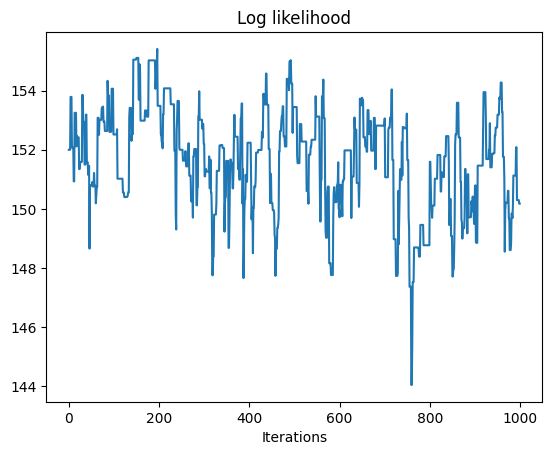

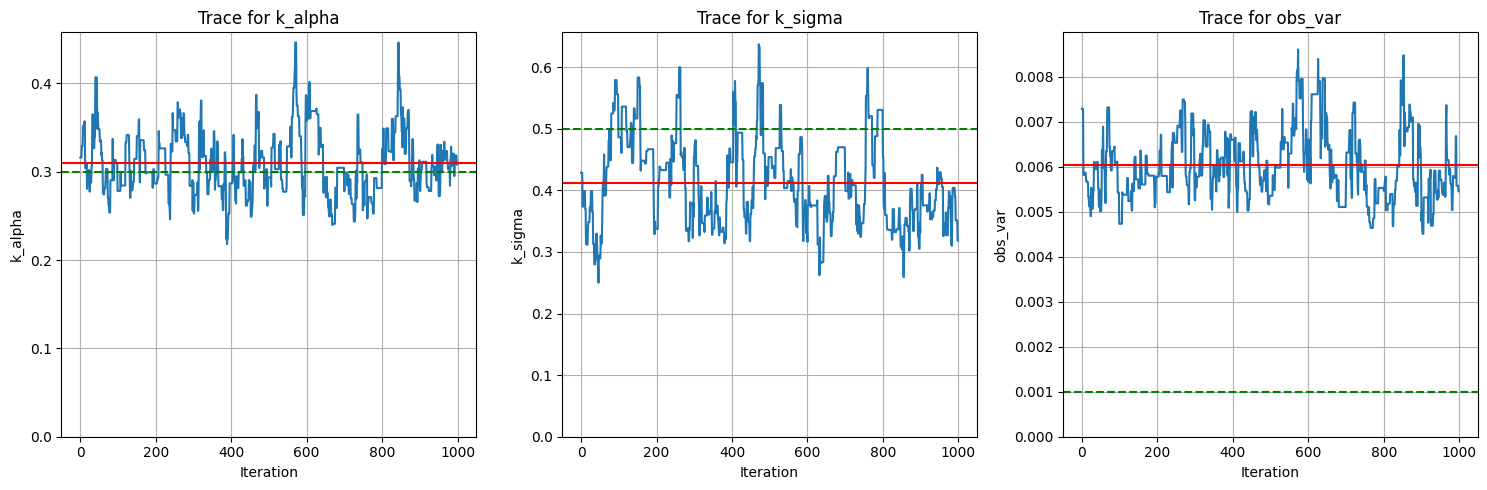

In [16]:
# inference for Gaussian model, likelihood from forward guiding

# Crank-Nicolson update with possibly node-dependent lambd
lambd = .9
update_CN = lambda noise,key: noise*lambd+jnp.sqrt((1-lambd**2))*jax.random.normal(key,noise.shape)

# downwards pass to compute likelihoods
tree.add_property('log_likelihood', shape=())
@jax.jit
def down_log_likelihood(noise,value,edge_length,parent_value,logw,params,**args):
    var = edge_length # variance is edge length
    return {'log_likelihood': jnp.mean(
        jax.vmap(lambda v,m,var,logw: logw+jax.scipy.stats.norm.logpdf(
            jax.vmap(lambda w: jnp.linalg.solve(sigma(m,params)/params['k_alpha'],w),1)((v-m).reshape((n,d))).flatten(),
            0,jnp.sqrt(var)*params['k_alpha']))(value,parent_value,var,logw)
        ,1)
        }
downmodel_log_likelihood = DownLambda(down_fn=down_log_likelihood)
down_log_likelihood = OrderedExecutor(downmodel_log_likelihood)

# log likelihood of the tree
def log_likelihood(data,state):
    """Log likelihood of the tree."""
    params,noise = state
    # backwards filtering with current parameters
    init_up(data,params); up.up(tree,params.values())
    # forwards guiding with current noise
    tree.data['noise'] = noise; down_conditional.down(tree,params.values())
    # compute log likelihood
    down_log_likelihood.down(tree,params.values())
    tree_log_likelihood = jnp.mean(tree.data['log_likelihood'][1:]) # ignore root node
    residuals = tree.data['value'][tree.is_leaf]-data
    leaves_log_likelihood = jnp.mean(jax.scipy.stats.norm.logpdf(residuals,0,jnp.sqrt(params['obs_var'].value)))
    return tree_log_likelihood+leaves_log_likelihood

def log_posterior(data,state):
    """Log posterior given the state and data."""
    parameters,_ = state
    log_prior = parameters.log_prior()
    log_like = log_likelihood(data,state)
    return log_prior + log_like

def proposal(data, state, key):
    subkeys = jax.random.split(key,2)
    parameters,noise = state

    # update parameters
    new_parameters = parameters.propose(subkeys[0])
    # update noise
    new_noise = update_CN(noise,subkeys[1])

    return new_parameters,new_noise

# tree values and parameters
init_params = ParameterStore({
    'k_alpha': VarianceParameter(.5,alpha=2,beta=.5), # kernel amplitude, governs global tree variance
    'k_sigma': VarianceParameter(.25,alpha=2,beta=.5), # kernel width, for Gaussian kernels this is proportional to the variance
    'obs_var': VarianceParameter(1e-3,alpha=2,beta=.003) # observation noise variance
    })
print("Initial parameters: ",init_params.values())
print("data parameters: ",params.values())

# initial state
init_state = (init_params,jnp.zeros_like(tree.data['noise']))

# Run Metropolis-Hastings
subkey, key = split(key)
log_likelihoods, samples = metropolis_hastings(log_posterior, proposal, leaf_values, init_state, 1000, burn_in=200, rng_key=key, savef=lambda state: state[0])

# plot
plt.plot(log_likelihoods)
plt.xlabel("Iterations")
plt.title('Log likelihood')
trace_plots(samples,params.values())